# Prediction notebook: Energy Emissions

## 1. Introduction

To support Seattle’s ambition of becoming a carbon-neutral city by 2050, the city is focusing on reducing emissions from non-residential buildings—currently among the largest contributors to greenhouse gas emissions. While detailed energy audits were carried out in 2016, these surveys are costly and time-consuming. The goal of this project is to build predictive models that estimate CO₂ emissions and total energy consumption of buildings using their structural and contextual features (e.g., size, usage type, year built, location). The project also explores the usefulness of the ENERGY STAR Score, a performance indicator that’s laborious to calculate, to determine whether it improves prediction performance enough to justify the effort.

Problem statement: Can we accurately predict the CO₂ emissions and total energy consumption of non-residential buildings in Seattle using their structural characteristics and available data, and what is the added predictive value of including the ENERGY STAR Score?

This notebook covers Milestone 2, 4 and 6:
* Development and simulation of a baseline model.
* Simulation of various models and a final choice of the best model.
* Analyse the influence of EnergyStarScore.

## 2. Environment Setup and Library Imports

In [3]:
# Core libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import warnings

# Data Preprocessing
from sklearn.preprocessing import StandardScaler

# Pipeline and composition tools
from sklearn.pipeline import Pipeline

# Model selection and evaluation
from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV, cross_validate, learning_curve)
from sklearn.metrics import (mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, confusion_matrix, PredictionErrorDisplay)
from math import sqrt

# Regression and Classification Algorithms
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Model interpretation
import shap
from sklearn.inspection import permutation_importance

# Configure environment
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid", context="notebook")
os.chdir('/Users/nataschajademinnitt/Documents/5. Data Analysis/open_classrooms/project_4')
print("Current directory:", os.getcwd())
warnings.filterwarnings("ignore")

Current directory: /Users/nataschajademinnitt/Documents/5. Data Analysis/open_classrooms/project_4


In [4]:
# Load the processed data file
df_feature_1 = pd.read_csv('./data/processed/feature_engineering_1_database.csv')

## 3. Define Helper Functions

### 3.1. CV Training Set Function

In [7]:
def cv_scores_df(model, X_train, y_train, cv=5):
    """
    Computes cross‑validation (CV) performance metrics using only the training data.
    Metrics: R², MAE, RMSE, and duration
    """
    
    scoring = {
        'r2': 'r2',
        'neg_mae': 'neg_mean_absolute_error',
        'neg_rmse': 'neg_root_mean_squared_error',
    }
    
    results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
    
    # Extract and adjust scores
    r2_scores = results['test_r2']
    mae_scores = -results['test_neg_mae']
    rmse_scores = -results['test_neg_rmse']
    duration = results['fit_time'] + results['score_time']
    
    scores = {
        'R2': {
            'Mean': np.mean(r2_scores),
            'Std': np.std(r2_scores)
        },
        'MAE': {
            'Mean': np.mean(mae_scores),
            'Std': np.std(mae_scores)
        },
        'RMSE': {
            'Mean': np.mean(rmse_scores),
            'Std': np.std(rmse_scores)
        },
        'Duration': {
            'Mean': np.mean(duration),
            'Std': np.std(duration)
        }
    }

    df_scores = pd.DataFrame(scores).T
    df_scores = df_scores.round(3)
    
    return df_scores

### 3.2. CV Train-Test Function

In [9]:
def holdout_train_test_scores_df(model, X_train, y_train, cv=5):
    """
    Performs cross-validation and returns a DataFrame with average performance metrics.
    Metrics: R² and Mean Absolute Error (MAE) for both training and test folds.
    """

    # Cross-Validation on the Training Data
    scoring = {
        'r2': 'r2',
        'neg_mae': 'neg_mean_absolute_error'
    }
    
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True)
    cv_train_r2 = np.mean(cv_results['train_r2'])
    cv_test_r2 = np.mean(cv_results['test_r2'])
    cv_train_mae = -np.mean(cv_results['train_neg_mae'])
    cv_test_mae = -np.mean(cv_results['test_neg_mae'])
    
    # Aggregate the scores into a DataFrame
    scores = {
        'CV Train': [cv_train_r2, cv_train_mae],
        'CV Test': [cv_test_r2, cv_test_mae]
    }
    
    df_scores = pd.DataFrame(scores, index=['R2', 'MAE'])
    return df_scores.round(3)

### 3.3. Performance on Unseen Data

In [11]:
def evaluate_models(models, X_train, y_train, X_test, y_test):
    """
    Evaluates a list of models on the test set and returns a DataFrame with performance metrics.
    Metrics: R², MAE, RMSE, and Duration.
    """
    
    results = {}
    for name, model in models:
        start = time.time()
        model.fit(X_train, y_train)
        end = time.time()
        y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        duration = end - start
        
        results[name] = (r2, mae, rmse, duration)
    
    df_results = pd.DataFrame(results, index=['R²', 'MAE', 'RMSE', 'Duration'])
    return df_results.T

### 3.4. Actual vs. Predicted Plot Function

In [13]:
def plot_actual_vs_predicted(model, X_test, y_test):
    """
    Creates and displays an actual vs. predicted plot using the fitted model.
    Assumes that the model has already been fitted.
    """
    y_pred = model.predict(X_test)
    fig, ax = plt.subplots(figsize=(7, 5))
    PredictionErrorDisplay.from_predictions(
        y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
    )
    ax.set_title(f"{type(model).__name__} - Actual vs. Predicted")
    mae = mean_absolute_error(y_test, y_pred)
    ax.plot([], [], " ", label=f"MAE: {mae:.2f}")
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.savefig(f"./results/figures/emissions/Actual vs Predicted/{name}.png", dpi=300)
    plt.show()

## 4. Model Evaluation Emissions

### 4.1. Prepare Data for Modeling

In [16]:
# Define features and target
df_model = df_feature_1.drop(columns=['log_energy_target', 'ENERGYSTARScore'])
df_model = df_model.dropna()
feature_cols = [col for col in df_model.columns if col not in ['log_emissions_target']]
X = df_model[feature_cols]
y = df_model['log_emissions_target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
# Dummy Regressor
model = DummyRegressor(strategy='median')
dummy_results = cv_scores_df(model, X_train, y_train, cv=5)
dummy_results

,Mean,Std
R2,-0.00500,0.00600
MAE,1.11900,0.03000
RMSE,1.41600,0.04300
Duration,0.00600,0.00600


### 4.2. Hyperparameter Tuning with GridSearchCV

In [19]:
# Define parameter grids for each estimator
param_grids = {
    "Linear Regression": {
        "model": [LinearRegression()],
        "model__fit_intercept": [True, False]
    },
    "Ridge": {
        "model": [Ridge()],
        "model__alpha": [0.01, 0.1, 1, 10, 100],
        "model__fit_intercept": [True, False]
    },
    "Lasso": {
        "model": [Lasso()],
        "model__alpha": [0.01, 0.1, 1, 10, 100],
        "model__fit_intercept": [True, False]
    },
    "Decision Tree": {
        "model": [DecisionTreeRegressor()],
        "model__max_depth": [5, 7, 9],
        "model__min_samples_split": [3, 5, 10],
        "model__min_samples_leaf": [1, 3, 5],
        "model__max_features": ['sqrt', 'log2'],
        "model__ccp_alpha": [0.0, 0.001, 0.01]
    },
    "Random Forest": {
        "model": [RandomForestRegressor(random_state=42)],
        "model__bootstrap": [True],
        "model__n_estimators": [100, 200],
        "model__max_depth": [5, 7, 9],
        "model__max_features": [2, 3],
        "model__min_samples_split": [3, 5]
    },
    "SVR": {
        "model": [SVR(kernel='linear')],
        "model__C": [0.1, 1],
        "model__epsilon": [0.1, 0.2, 0.5]
    },
    "XGBRegressor": {
        "model": [XGBRegressor(random_state=42)],
        "model__learning_rate": [0.05, 0.1, 0.2],
        "model__n_estimators": [50, 100, 200],
        "model__max_depth": [3, 5]
    },
    "LightGBM Regressor": {
        "model": [LGBMRegressor(random_state=42, verbose=-1)],
        "model__n_estimators": [50, 100, 200],
        "model__learning_rate": [0.05, 0.1, 0.2],
        "model__max_depth": [3, 5]
    }
}

# Dictionaries
all_results = []
best_params_dict = {}
best_models = {}

# Loop over each estimator's grid, run GridSearchCV, and store best results and models
for name, grid in param_grids.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', grid['model'][0])
    ])
    gs = GridSearchCV(pipe, grid, cv=5, scoring='r2', verbose=1)
    gs.fit(X_train, y_train)
    
    # DF for CV results
    df_cv = pd.DataFrame(gs.cv_results_)
    df_cv['model_name'] = name
    all_results.append(df_cv)
    
    # Best parameters and best estimator
    best_params_dict[name] = gs.best_params_
    best_models[name] = gs.best_estimator_

# Extract the final models
final_models = [(name, model) for name, model in best_models.items()]

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [20]:
# Combine all CV results into one DataFrame
combined_results = pd.concat(all_results, ignore_index=True)
combined_results = combined_results[combined_results['rank_test_score'] == 1]
combined_results = combined_results.sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
combined_results[['model_name', 'params', 'mean_test_score', 'std_test_score', 'mean_fit_time']].head(8)

,model_name,params,mean_test_score,std_test_score,mean_fit_time
0,LightGBM Regressor,"{'model': LGBMRegressor(learning_rate=0.05, max_depth=5, n_estimators=200, random_state=42, verbose=-1), 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 200}",0.80365,0.04705,0.05447
1,XGBRegressor,"{'model': XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.1, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=3, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=200, n_jobs=None, num_parallel_tree=None, random_state=42, ...), 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}",0.79854,0.04910,0.04414
2,Lasso,"{'model': Lasso(alpha=0.01), 'model__alpha': 0.01, 'model__fit_intercept': True}",0.78636,0.05720,0.00956
3,Linear Regression,"{'model': LinearRegression(), 'model__fit_intercept': True}",0.77940,0.06111,0.03283
4,Ridge,"{'model': Ridge(alpha=10), 'model__alpha': 10, 'model__fit_intercept': True}",0.77590,0.06627,0.00361
5,SVR,"{'model': SVR(C=1, epsilon=0.5, kernel='linear'), 'model__C': 1, 'model__epsilon': 0.5}",0.73730,0.13239,0.04927
6,Random Forest,"{'model': RandomForestRegressor(max_depth=9, max_features=3, min_samples_split=3, n_estimators=200, random_state=42), 'model__bootstrap': True, 'model__max_depth': 9, 'model__max_features': 3, 'model__min_samples_split': 3, 'model__n_estimators': 200}",0.66177,0.03817,0.09707
7,Decision Tree,"{'model': DecisionTreeRegressor(max_depth=9, max_features='sqrt', min_samples_leaf=5, min_samples_split=10), 'model__ccp_alpha': 0.0, 'model__max_depth': 9, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 10}",0.59837,0.02689,0.00150


### 4.3. CV Training Set Scores

* Purpose: Reports cross‐validation metrics (R², MAE, RMSE, and duration) using only the training set.
* Use Case: To understand how your model performs on different subsets of your training data and to check for overfitting or high variability.

In [22]:
for name, model in final_models:
    df_results = cv_scores_df(model, X_train, y_train, cv=5)
    print("\nModel:", name, "\n")
    print(df_results)
    print("." * 20)


Model: Linear Regression 

            Mean     Std
R2       0.77900 0.06100
MAE      0.47800 0.04400
RMSE     0.65600 0.09700
Duration 0.06100 0.07100
....................

Model: Ridge 

            Mean     Std
R2       0.77600 0.06600
MAE      0.47300 0.03900
RMSE     0.66000 0.09600
Duration 0.00300 0.00100
....................

Model: Lasso 

            Mean     Std
R2       0.78600 0.05700
MAE      0.47200 0.03800
RMSE     0.64500 0.08100
Duration 0.00400 0.00200
....................

Model: Decision Tree 

            Mean     Std
R2       0.57000 0.07600
MAE      0.70400 0.06500
RMSE     0.92200 0.08300
Duration 0.00200 0.00000
....................

Model: Random Forest 

            Mean     Std
R2       0.66200 0.03800
MAE      0.63800 0.02700
RMSE     0.81900 0.03300
Duration 0.12300 0.02000
....................

Model: SVR 

            Mean     Std
R2       0.73700 0.13200
MAE      0.47600 0.04000
RMSE     0.70400 0.17700
Duration 0.05100 0.00300
....................

M

Observations:
* Both regularized linear models perform much better than plain Linear Regression, with Lasso slightly outperforming Ridge in terms of R² and RMSE.
* Decision models underperform relative to others, indicating it might be too simple or overfitting the data.
* The boosting models achieve the best R² and the lowest errors, suggesting they capture the underlying patterns effectively. 

### 4.4. CV Train-Test Results

* Purpose: Evaluates the model’s performance via CV on the training set, reporting metrics separately for the training folds and the validation folds within CV.
* Use Case: To compare the CV performance on the training folds (which might be optimistic) with the CV performance on the validation folds—this can help diagnose overfitting.

In [25]:
for name, model in final_models:
    df_holdout = holdout_train_test_scores_df(model, X_train, y_train, cv=5)
    print("\nModel:", name, "\n")
    print(df_holdout)
    print("." * 20)


Model: Linear Regression 

     CV Train  CV Test
R2    0.82700  0.77900
MAE   0.45300  0.47800
....................

Model: Ridge 

     CV Train  CV Test
R2    0.82900  0.77600
MAE   0.44700  0.47300
....................

Model: Lasso 

     CV Train  CV Test
R2    0.82400  0.78600
MAE   0.45100  0.47200
....................

Model: Decision Tree 

     CV Train  CV Test
R2    0.67600  0.54100
MAE   0.61200  0.73900
....................

Model: Random Forest 

     CV Train  CV Test
R2    0.78300  0.66200
MAE   0.51700  0.63800
....................

Model: SVR 

     CV Train  CV Test
R2    0.82800  0.73700
MAE   0.45000  0.47600
....................

Model: XGBRegressor 

     CV Train  CV Test
R2    0.93300  0.79900
MAE   0.27600  0.47000
....................

Model: LightGBM Regressor 

     CV Train  CV Test
R2    0.92000  0.80400
MAE   0.30200  0.46100
....................


Observations:
* Ridge, Lasso demonstrate much more stable performance, indicating better generalization.
* Boosting methods (XGBRegressor and LightGBM Regressor) have the highest overall performance, with high CV test R² values and low errors.
* Decision Tree and Random Forest perform relatively worse.

### 4.5. Performance on Unseen Data

* Purpose: Fits the model on the training set and then evaluates its performance on a separate, unseen holdout test set.
* Use Case: To provide a final, unbiased evaluation of how the model will perform on completely unseen data, ensuring that there’s no leakage from the training process.

In [28]:
eval_df = evaluate_models(final_models, X_train, y_train, X_test, y_test)
eval_df

,R²,MAE,RMSE,Duration
Linear Regression,0.81926,0.48869,0.64556,0.01212
Ridge,0.81988,0.48820,0.64444,0.00385
Lasso,0.81945,0.48650,0.64521,0.01417
Decision Tree,0.70188,0.62923,0.82909,0.00397
Random Forest,0.66933,0.67317,0.87318,0.20785
SVR,0.81930,0.49023,0.64548,0.08502
XGBRegressor,0.83536,0.46154,0.61613,0.04191
LightGBM Regressor,0.83193,0.46439,0.62251,0.04898


Observation:
* Boosting models (LightGBM and XGBRegressor) and SVR deliver the strongest performance on unseen data, with LightGBM showing the best overall metrics (highest R² and lowest MAE and RMSE).

## 5. Model Interpretation

### 5.1. Plot Actual vs. Predicted

Plotting for Linear Regression


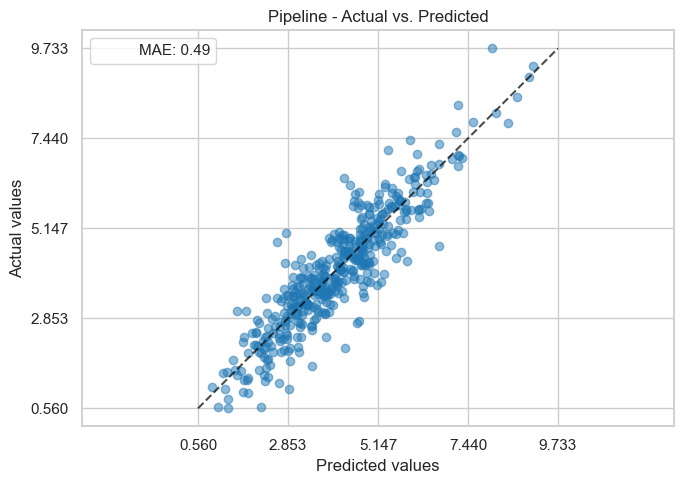

Plotting for Ridge


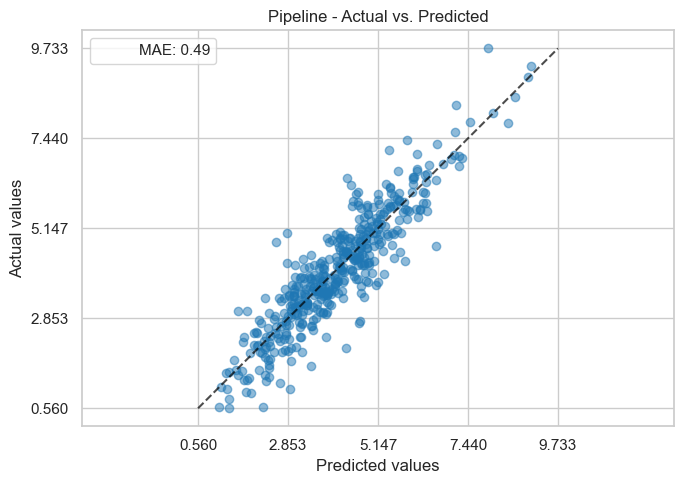

Plotting for Lasso


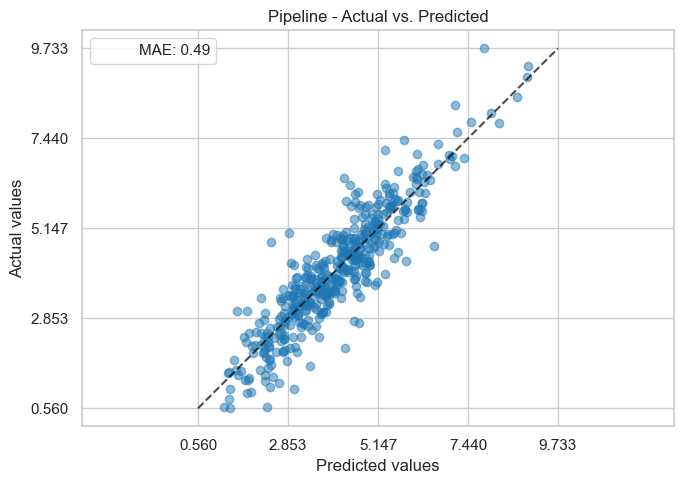

Plotting for Decision Tree


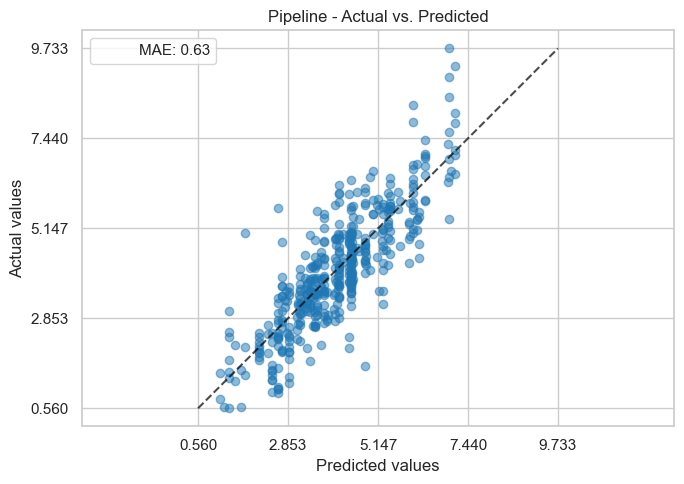

Plotting for Random Forest


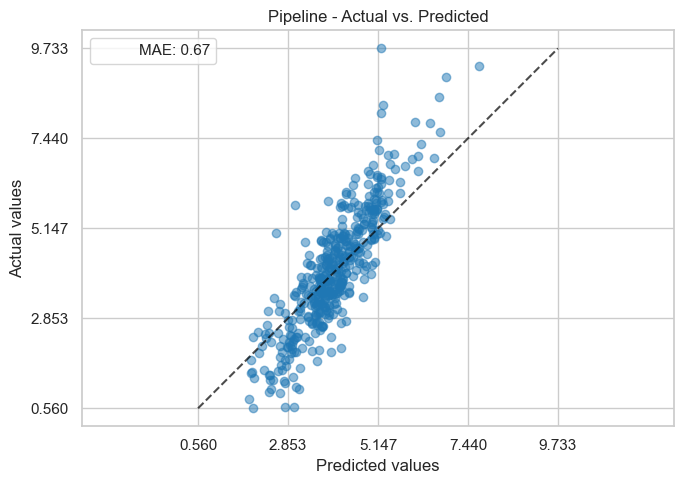

Plotting for SVR


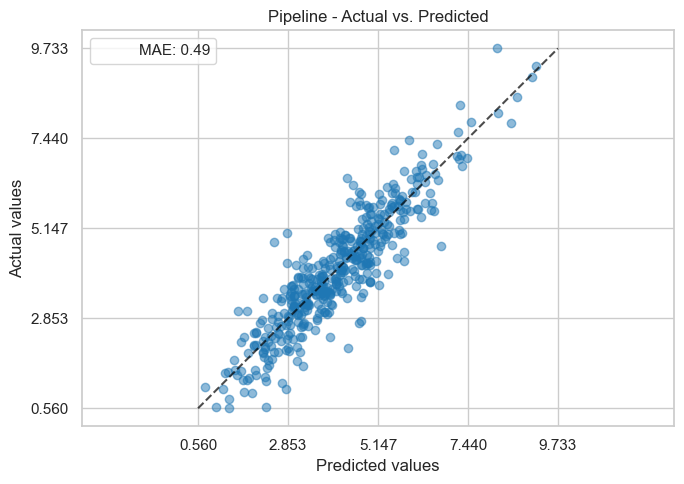

Plotting for XGBRegressor


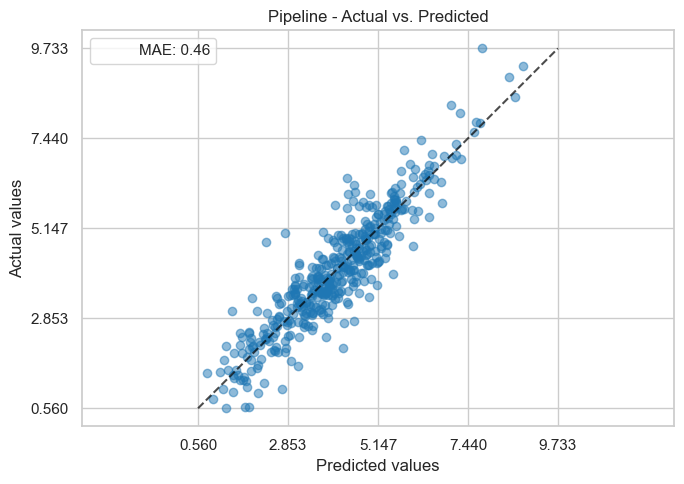

Plotting for LightGBM Regressor


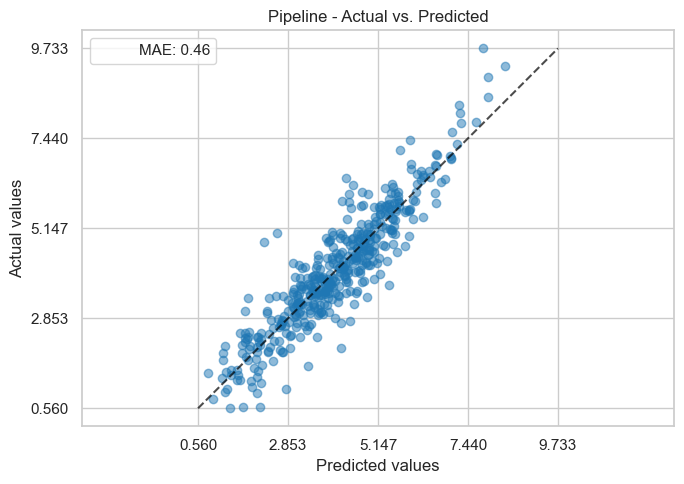

In [32]:
for name, model in final_models:
    print(f"Plotting for {name}")
    plot_actual_vs_predicted(model, X_test, y_test)

### 5.2. Global Feature Importance from Linear Models

In linear models, coefficients directly represent the change in the target variable per unit change in the predictor. Thus, they can be interpreted as a measure of importance.

In [35]:
linear_model_names = ["Ridge", "Lasso"]
linear_models = [(name, best_models[name]) for name in linear_model_names if name in best_models]

coefficients = {}
for name, model in linear_models:
    estimator = model.named_steps['model']
    coefficients[name] = estimator.coef_

coef_df = pd.DataFrame(coefficients, index=X_train.columns)
coef_df.sort_values(by='Ridge', key=abs, ascending=False)

,Ridge,Lasso
natural_gas_rate,0.94394,0.80497
log_PropertyGFATotal,0.86853,0.88413
steam_rate,0.40289,0.35092
prop_cluster_1,-0.17909,-0.26041
prop_cluster_2,0.17200,0.15796
PrimaryPropertyType_Supermarket / Grocery Store,0.14765,0.14698
electricity_rate,0.13342,0.00000
ParkingProportion,-0.12942,-0.10566
PrimaryPropertyType_Warehouse,-0.12068,-0.07789
prop_cluster_0,0.10815,0.05118


Lasso models tend to shrink coefficients and sometimes set them to zero (as seen with natural_gas_rate), which can indicate redundancy or lower predictive power for those features. Essneitally performing a feature selection.

### 5.3. Best Model

In [38]:
overall_best_name = max(best_params_dict, key=lambda name: best_models[name].score(X_test, y_test))
best_model = best_models[overall_best_name]
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

#### 5.3.1. Feature Importance

The feature importance values come from your tree‑based model (e.g., XGBRegressor or LightGBM). They indicate how much each feature contributes to reducing prediction error. A higher normalized importance (given as a percentage) means that the feature is more influential in the model’s decisions.

In [40]:
# Extract feature importance coefficients
selected_model = best_model.named_steps['model']
importances = selected_model.feature_importances_

fi_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})
fi_df = fi_df.sort_values(by='importance', ascending=False)
fi_df['normalized_importance'] = ((fi_df['importance'] / fi_df['importance'].sum().round(2)) * 100)
fi_df

,feature,importance,normalized_importance
6,log_PropertyGFATotal,0.19791,19.79120
2,electricity_rate,0.15054,15.05442
9,prop_cluster_1,0.13722,13.72233
8,prop_cluster_0,0.06877,6.87671
10,prop_cluster_2,0.05242,5.24203
27,PrimaryPropertyType_Supermarket / Grocery Store,0.05161,5.16078
21,PrimaryPropertyType_Other,0.03018,3.01760
4,steam_rate,0.02408,2.40774
3,natural_gas_rate,0.02073,2.07313
30,PrimaryPropertyType_Worship Facility,0.01956,1.95629


Observation:
* electricity_rate and log_PropertyGFATotal together account for nearly 38% of the model's decision-making, highlighting the importance of energy composition and building size.
* The cluster-based features (prop_cluster_1, etc.) show that grouping property types adds value compared to using raw categorical data.
* Many neighborhood and specific property type variables have minimal importance, indicating that the model finds their incremental contribution to emissions prediction negligible once the other features are accounted for.

#### 5.3.2. SHAP for Model Explanations

This function calls the predict method on the pipeline (best_model). Since the pipeline includes both a scaler and the LightGBM model, calling predict on it applies all the necessary preprocessing (e.g., scaling) before making predictions. This ensures that the data passed to SHAP is processed exactly as it was during model training.

By passing the pipeline_predict function and the original training data (X_train), SHAP internally uses the complete pipeline to generate predictions. The training data also serves as the background data for SHAP, which is used to compute baseline predictions and explain deviations from that baseline.

In [44]:
def pipeline_predict(X):
    return best_model.predict(X)

explainer = shap.Explainer(
    pipeline_predict,
    X_train
)
shap_values = explainer(X_train)

PermutationExplainer explainer: 1020it [00:16, 25.70it/s]                          


**Global feature importance**

We use SHAP to obtain a model-agnostic explanation of the overall impact of each feature on the model's predictions. The SHAP summary (beeswarm) plot aggregates SHAP values across all samples, making it easy to see which features drive the predictions the most.

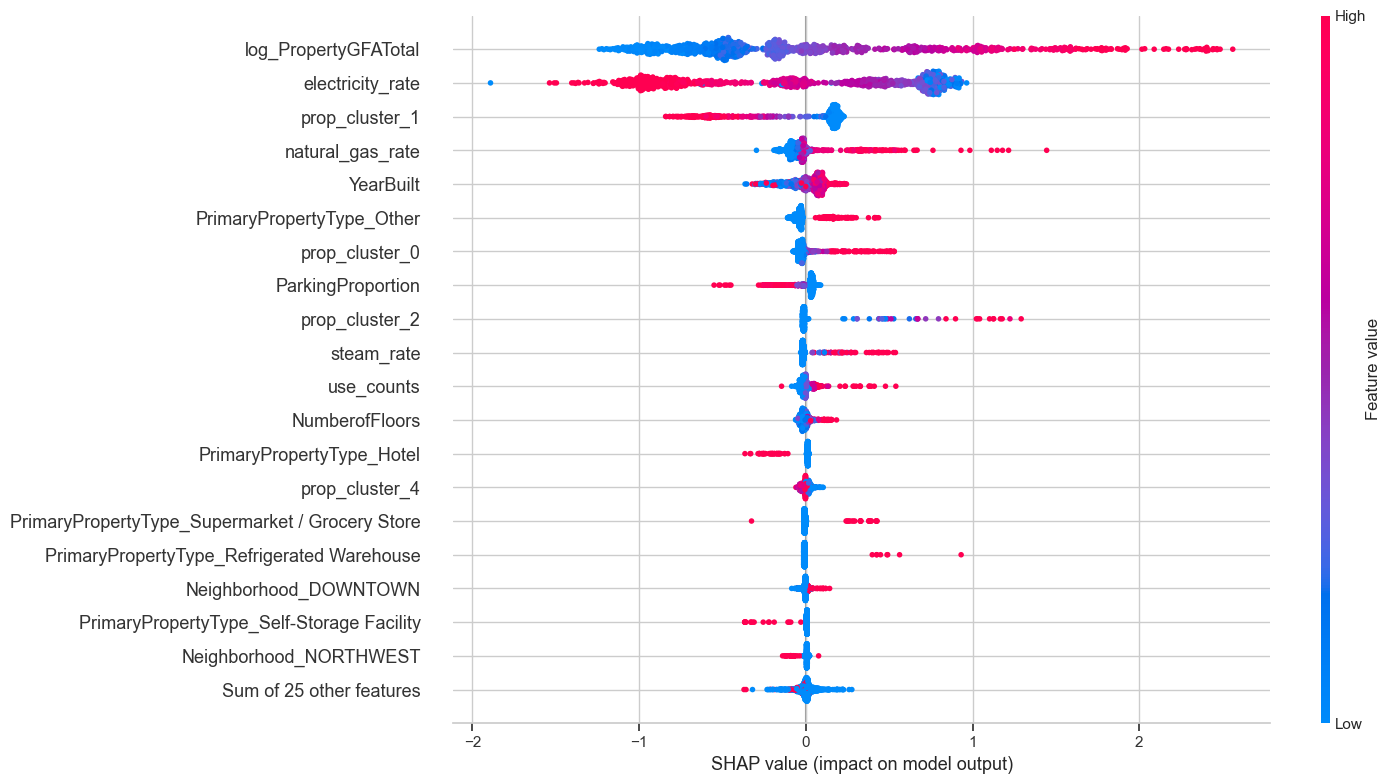

In [46]:
shap.plots.beeswarm(shap_values, max_display=20, show=False)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.tight_layout()
fig.savefig("./results/figures/emissions/global_shap_beeswarm.png")
plt.show()

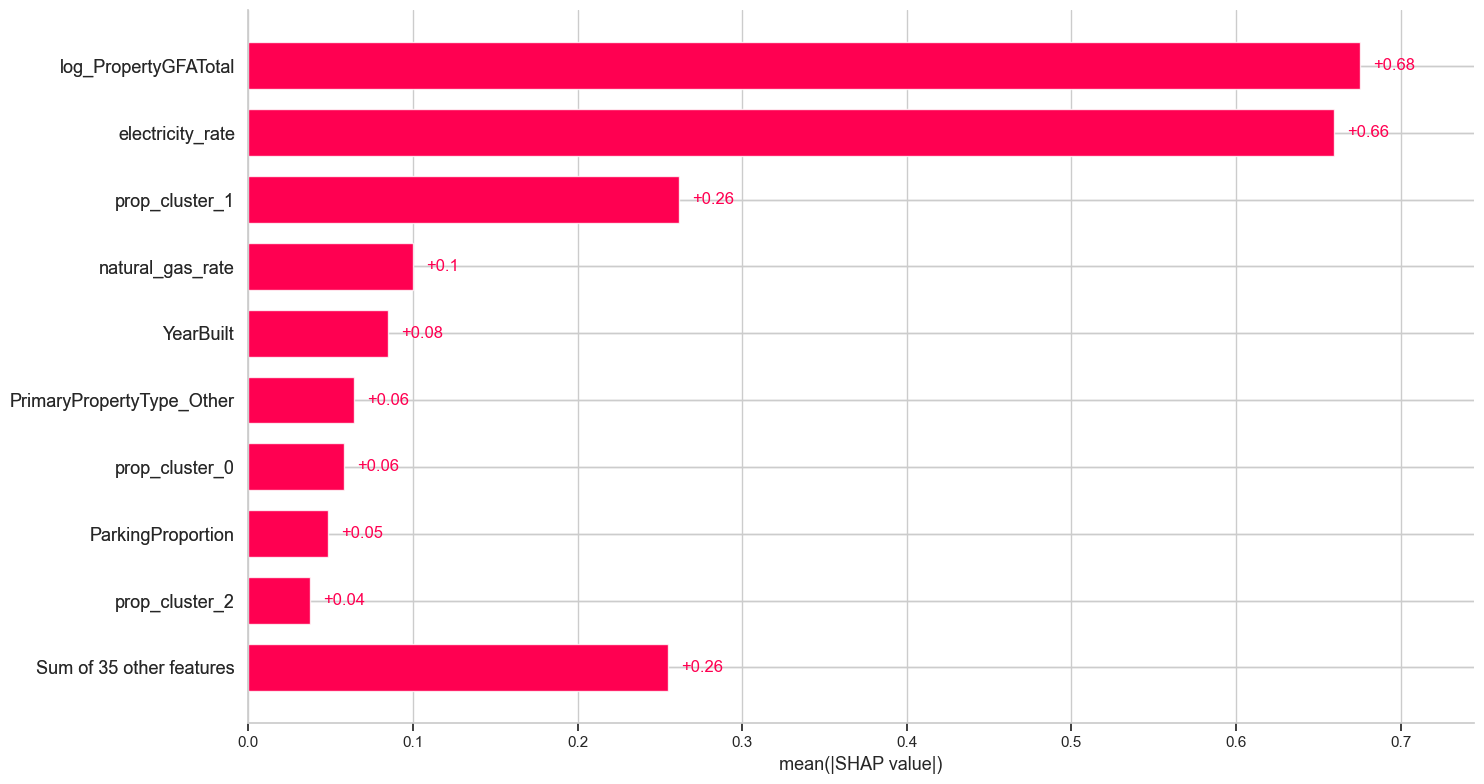

In [47]:
shap.plots.bar(shap_values, max_display=10, show=False)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.tight_layout()
fig.savefig("./results/figures/emissions/global_shap_bar.png", dpi=300)
plt.show()

**Local feature importance**

For individual buildings, we generate SHAP force plots that illustrate the contribution of each feature to that specific prediction. This helps us understand the model's decision-making on a case-by-case basis.

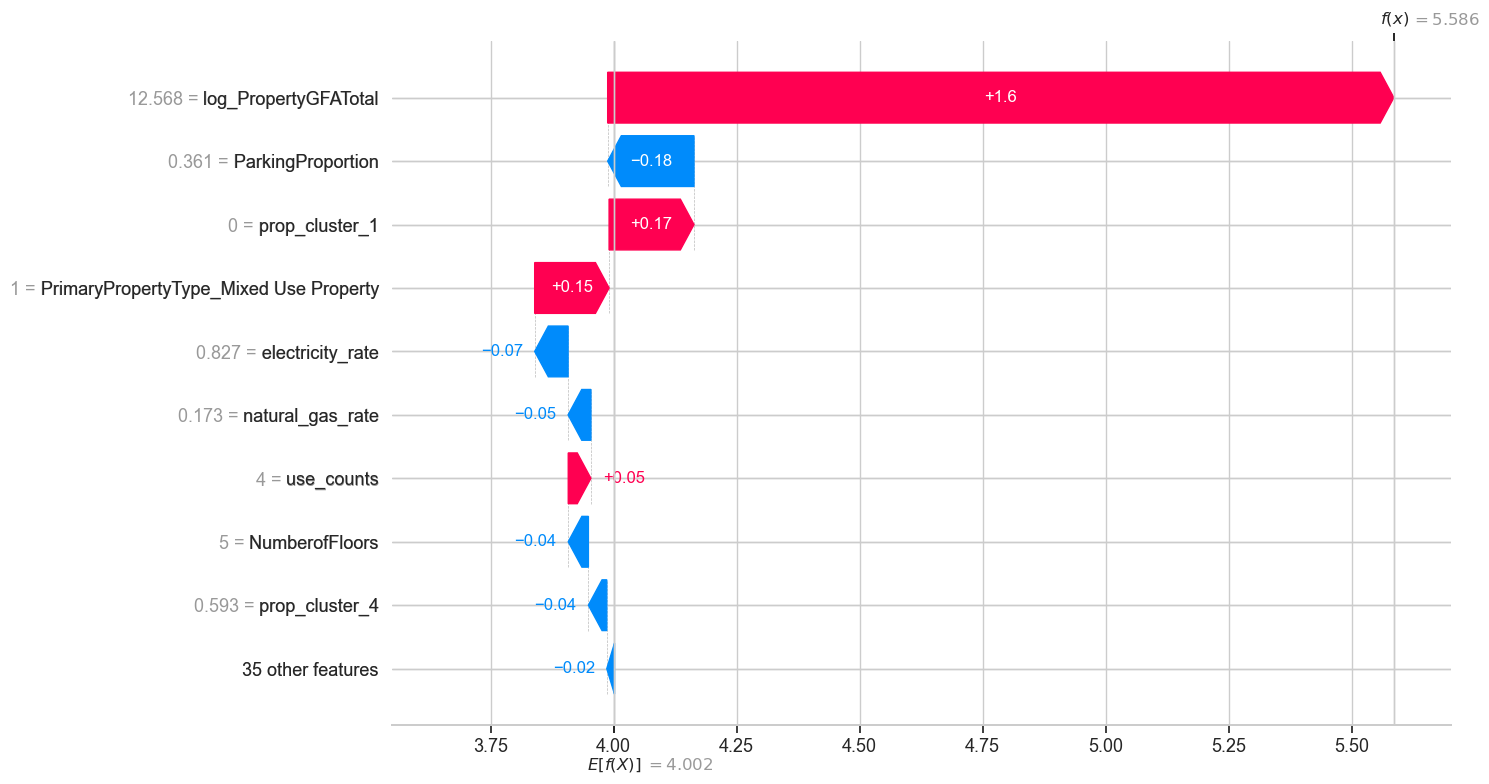

In [49]:
shap.plots.waterfall(shap_values[0], show=False)
fig = plt.gcf()
fig.canvas.draw()
fig.set_size_inches(15, 8)
plt.tight_layout()
fig.savefig("./results/figures/emissions/local_shap_waterfall.png", dpi=300)
plt.show()

## 6. Model Evaluation Emissions with Energy Score

In [51]:
df_energy = df_feature_1.drop(columns=['log_energy_target'])
df_energy = df_energy[df_energy['ENERGYSTARScore'].notna()]

y_energy = df_energy['log_emissions_target']
X_with = df_energy.drop('log_emissions_target', axis=1)
X_without = X_with.drop('ENERGYSTARScore', axis=1)

# Train-test split
X_with_train, X_with_test, y_energy_train, y_energy_test = train_test_split(X_with, y_energy, test_size=0.2, random_state=42)
X_without_train, X_without_test, y_energy_train, y_energy_test = train_test_split(X_without, y_energy, test_size=0.2, random_state=42)

In [52]:
# Pipeline for LGBMRegressor
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(random_state=42))
])

param_grid = {
    "model__learning_rate": [0.05, 0.1, 0.2],
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [3, 5]
}

# GridSearch with EnergyStarScore
gs_with = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', verbose=1)
gs_with.fit(X_with_train, y_energy_train)
best_model_with = gs_with.best_estimator_
y_pred_with = best_model_with.predict(X_with_test)

# GridSearch without EnergyStarScore
gs_without = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', verbose=1)
gs_without.fit(X_without_train, y_energy_train)
best_model_without = gs_without.best_estimator_
y_pred_without = best_model_without.predict(X_without_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [53]:
# Model metrics with EnergyStarScore
print("." * 50)
print("Evaluation with EnergyStarScore:")
eval_with = evaluate_models([("XGBRegressor", best_model_with)], X_with_train, y_energy_train, X_with_test, y_energy_test)
print(eval_with)
print("." * 50)

# Model metrics without EnergyStarScore
print("Evaluation without EnergyStarScore:")
eval_without = evaluate_models([("XGBRegressor", best_model_without)], X_without_train, y_energy_train, X_without_test, y_energy_test)
print(eval_without)

..................................................
Evaluation with EnergyStarScore:
                  R²     MAE    RMSE  Duration
XGBRegressor 0.93187 0.28758 0.38236   0.05734
..................................................
Evaluation without EnergyStarScore:
                  R²     MAE    RMSE  Duration
XGBRegressor 0.88332 0.38322 0.50039   0.02861


In [54]:
def pipeline_predict(X):
    return best_model_with.predict(X)

explainer_with = shap.Explainer(
    pipeline_predict,
    X_with_train
)
shap_values_with = explainer_with(X_with_train)

PermutationExplainer explainer: 753it [00:11,  8.77it/s]                         


In [55]:
def pipeline_predict(X):
    return best_model_without.predict(X)

explainer_without = shap.Explainer(
    pipeline_predict,
    X_without_train
)
shap_values_without = explainer_without(X_without_train)

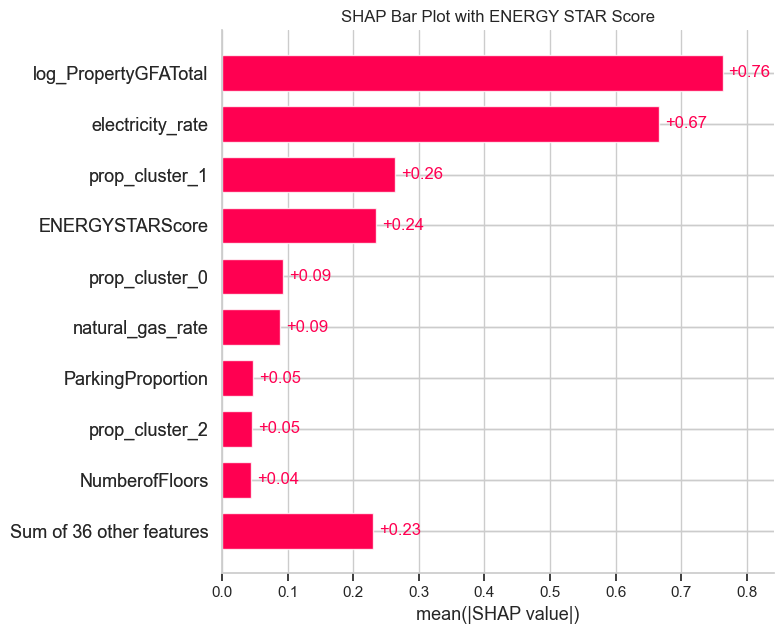

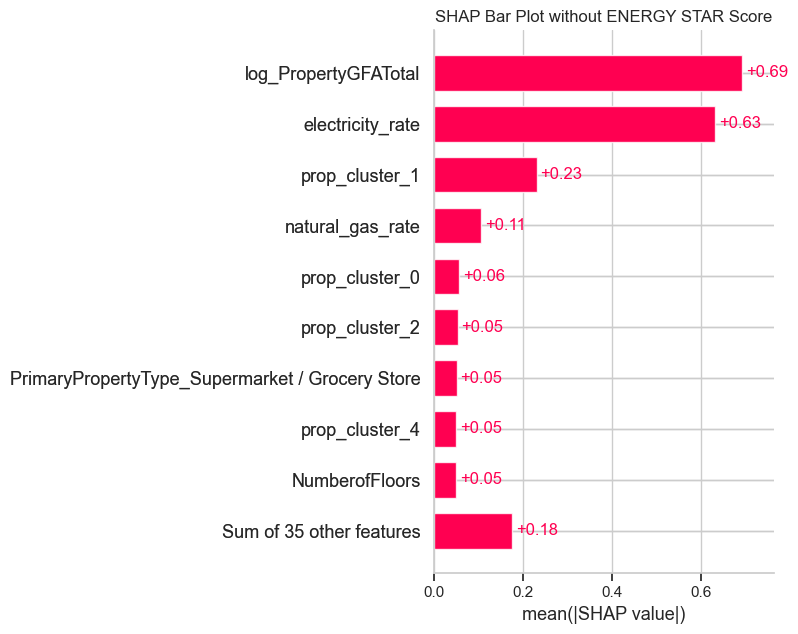

In [56]:
# Plot
shap.plots.bar(shap_values_with, max_display=10, show=False)
plt.title("SHAP Bar Plot with ENERGY STAR Score")
plt.tight_layout()
plt.savefig("./results/figures/emissions/shap_bar_with_energystarscore.png")
plt.show()

# Plot
shap.plots.bar(shap_values_without, max_display=10, show=False)
plt.title("SHAP Bar Plot without ENERGY STAR Score")
plt.tight_layout()
plt.savefig("./results/figures/emissions/shap_bar_without_energystarscore.png")
plt.show()

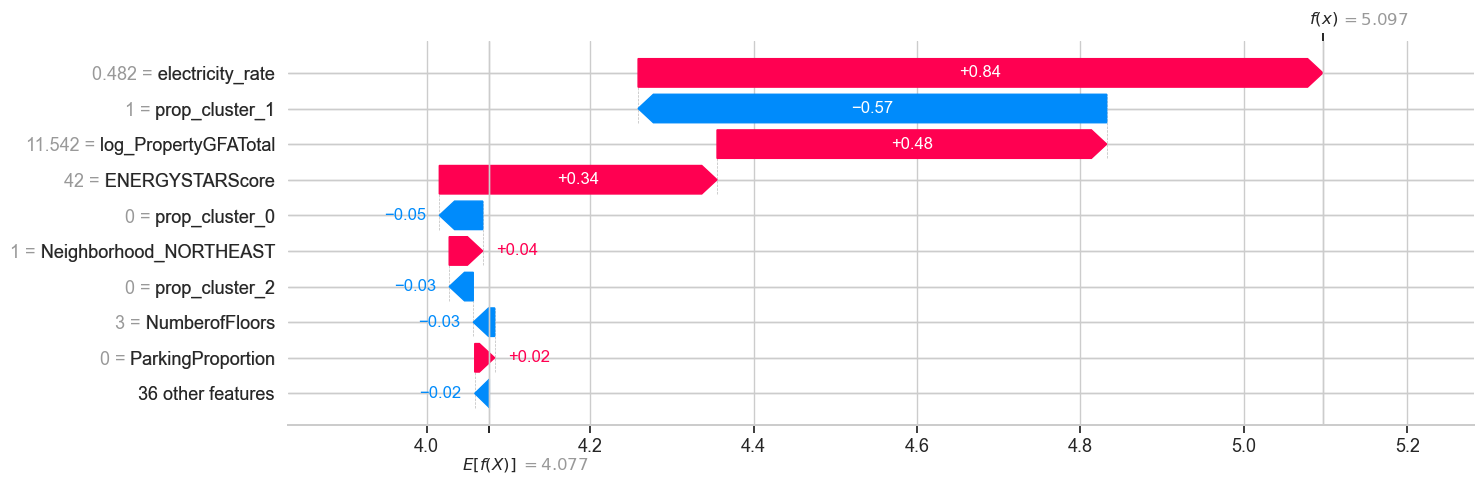

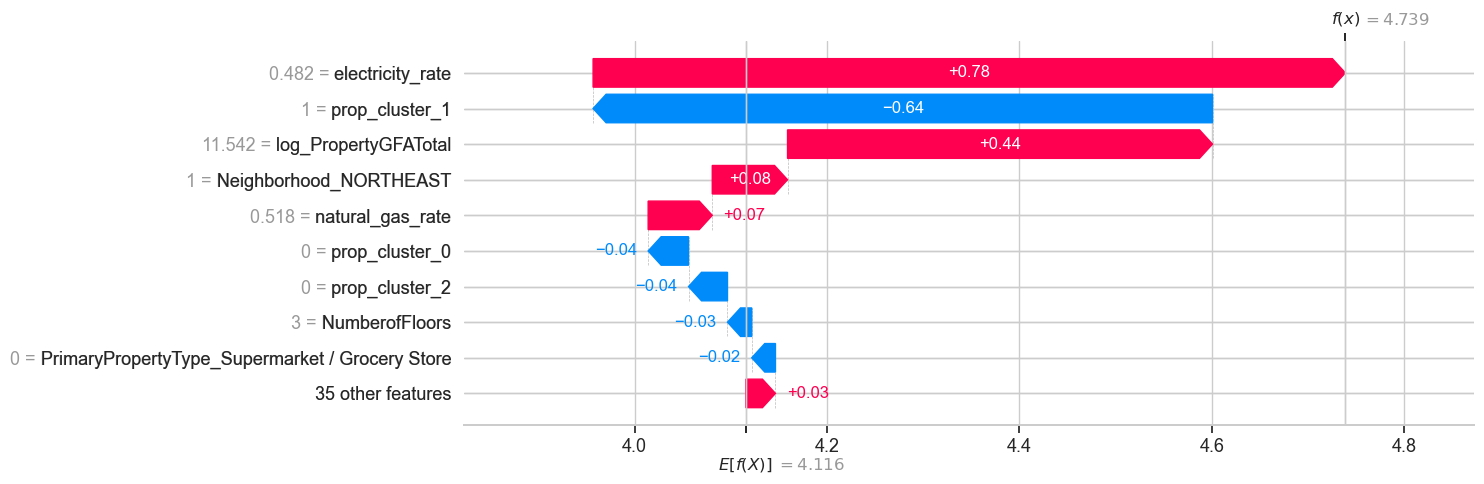

In [57]:
shap.plots.waterfall(shap_values_with[0], show=False)
fig = plt.gcf()
fig.canvas.draw()
fig.set_size_inches(15, 5)
plt.tight_layout()
fig.savefig("./results/figures/emissions/shap_local_with_energystarscore.png", dpi=300)
plt.show()

shap.plots.waterfall(shap_values_without[0], show=False)
fig = plt.gcf()
fig.canvas.draw()
fig.set_size_inches(15, 5)
plt.tight_layout()
fig.savefig("./results/figures/emissions/shap_local_without_energystarscore.png", dpi=300)
plt.show()

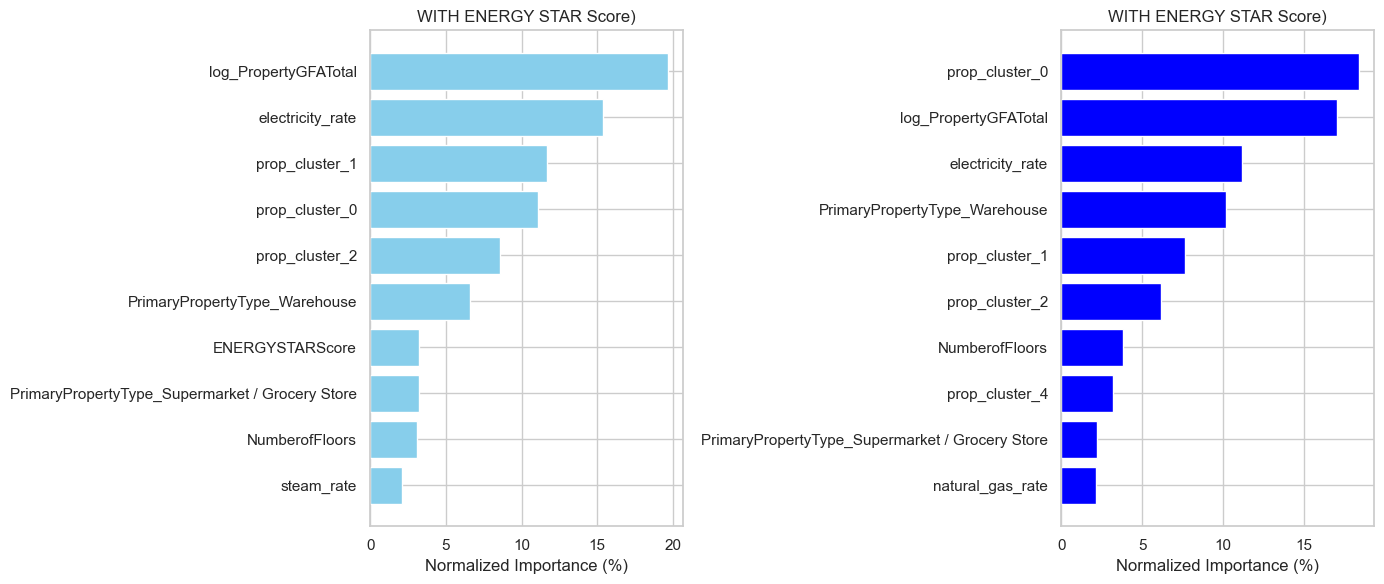

In [58]:
# For the model WITH ENERGY STAR Score:
selected_model_with = best_model_with.named_steps['model']
importances_with = selected_model_with.feature_importances_
fi_df_with = pd.DataFrame({
    'feature': X_with_train.columns,
    'importance': importances_with
})
fi_df_with = fi_df_with.sort_values(by='importance', ascending=False)
fi_df_with['normalized_importance'] = (fi_df_with['importance'] / fi_df_with['importance'].sum()) * 100

# For the model WITHOUT ENERGY STAR Score:
selected_model_without = best_model_without.named_steps['model']
importances_without = selected_model_without.feature_importances_
fi_df_without = pd.DataFrame({
    'feature': X_without_train.columns,
    'importance': importances_without
})
fi_df_without = fi_df_without.sort_values(by='importance', ascending=False)
fi_df_without['normalized_importance'] = (fi_df_without['importance'] / fi_df_without['importance'].sum()) * 100

# Plot feature importance
top10_with = fi_df_with.head(10)
top10_without = fi_df_without.head(10)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.barh(top10_with['feature'], top10_with['normalized_importance'], color='skyblue')
ax1.invert_yaxis()
ax1.set_title('WITH ENERGY STAR Score)')
ax1.set_xlabel('Normalized Importance (%)')

ax2.barh(top10_without['feature'], top10_without['normalized_importance'], color='blue')
ax2.invert_yaxis()
ax2.set_title('WITH ENERGY STAR Score)')
ax2.set_xlabel('Normalized Importance (%)')

plt.tight_layout()
plt.savefig('./results/figures/emissions/top10_feature_importance_comparison.png')
plt.show()